# Tensorflow implementation 03: RNN

by [Sho Nakagome](https://github.com/shonaka)

This jupyter notebook is intended to implement a simple RNN (Recurrent Neural Network) model on predicting sequential time series. For the data, we will be using Bitcoin historical price data available [here](http://api.bitcoincharts.com/v1/csv/).

RNN is more suitable to be used when trained with sequential data (e.g. time series, voice recognition, stock prices, etc). In this jupyter notebook, we will focus on implemeting the RNN itself and I'll leave the explanation of its theory and algorithms to other sources on the internet.

## Imports

In [1]:
import tensorflow as tf
import tflearn
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
# Just for visualization in jupyter notebook purposes
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

/home/snakagom/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Programming environment: Python 3.6 (Anaconda)

In [2]:
tf.__version__

'1.5.0'

## Define global variables

Let's define some global variables to be used in the code. Don't worry about this for now since we will be describing these in the later part of the notebooks when these appear.

In [3]:
# RNN related
NUM_HIDDEN = 32  # Number of hidden units in a hidden layer

# Optimization related
LEARNING_RATE = 1e-4
BATCH_SIZE = 32  # Better to have a batch size 2^n
NUM_EPOCHS = 100

## Import data and checking the dataset

We will be importing data using pandas. [Pandas](https://pandas.pydata.org/) is a very good library to handle data structures and processing, like the .csv file we are going to use in this notebook. To know more about the library, go check the website linked in the beginning of this sentence.

In [4]:
# Load the data
df = pd.read_csv('data/.coinbaseUSD.csv')

Since the .csv file is a little over 150MB, it might take a while.

Once the loading is done, let's check the dataset a bit.

In [5]:
# Show the first n = 10 rows
df.head(10)

,1417412036,300.000000000000,0.010000000000
0,1417412423,300.00,0.010000
1,1417415048,370.00,0.010000
2,1417416612,370.00,0.026556
3,1417498166,377.00,0.010000
4,1417517949,377.75,0.250000
5,1417517949,378.00,3.750000
6,1417518257,378.00,4.900000
7,1417518340,378.00,5.200000
8,1417545780,378.00,0.100000
9,1417546703,378.00,0.793600


As you could see, the data is a little difficult to decipher. Let's put some titles to the columns and encode the date so that we could easily interpret the data. 

In [6]:
# Adding column labels
df.columns = ['TimeStamp', 'PriceUSD', 'Volume']
df.head() # default n = 5

,TimeStamp,PriceUSD,Volume
0,1417412423,300.00,0.010000
1,1417415048,370.00,0.010000
2,1417416612,370.00,0.026556
3,1417498166,377.00,0.010000
4,1417517949,377.75,0.250000


In [7]:
# Encode the date and replace the index by the date
df.TimeStamp= pd.to_datetime(df['TimeStamp'], unit='s')

# Change the index with the encoded date
df.index = df.TimeStamp

# Show the data just for checking
df.head()

,TimeStamp,PriceUSD,Volume
TimeStamp,,,
2014-12-01 05:40:23,2014-12-01 05:40:23,300.00,0.010000
2014-12-01 06:24:08,2014-12-01 06:24:08,370.00,0.010000
2014-12-01 06:50:12,2014-12-01 06:50:12,370.00,0.026556
2014-12-02 05:29:26,2014-12-02 05:29:26,377.00,0.010000
2014-12-02 10:59:09,2014-12-02 10:59:09,377.75,0.250000


Now that we have the data organized, we will group them by day and month to see the trends.

In [8]:
# Group by day
df_day = df.resample('D').mean()

# Group by month
df_month = df.resample('M').mean()

Let's check each of the resampled data.

In [9]:
df_day.head(10)

,PriceUSD,Volume
TimeStamp,,
2014-12-01,346.666667,0.015519
2014-12-02,377.843750,1.876700
2014-12-03,377.818333,0.091101
2014-12-04,377.100000,0.010000
2014-12-05,NaN,NaN
2014-12-06,378.000000,0.015000
2014-12-07,NaN,NaN
2014-12-08,375.005000,0.117500
2014-12-09,NaN,NaN


In [10]:
df_month.head(10)

,PriceUSD,Volume
TimeStamp,,
2014-12-31,369.758667,0.701225
2015-01-31,240.810146,0.816935
2015-02-28,236.607541,0.638448
2015-03-31,271.115614,0.525017
2015-04-30,235.304800,0.620728
2015-05-31,237.432032,0.439390
2015-06-30,239.497082,0.362127
2015-07-31,280.393456,0.366728
2015-08-31,242.787177,0.556696


Now you see that there's some missing day transactions in df_day and we will be removing the day with Nans.

In [11]:
# Removing the rows with Nans
df_day = df_day.dropna()
df_day.head(10)

,PriceUSD,Volume
TimeStamp,,
2014-12-01,346.666667,0.015519
2014-12-02,377.843750,1.876700
2014-12-03,377.818333,0.091101
2014-12-04,377.100000,0.010000
2014-12-06,378.000000,0.015000
2014-12-08,375.005000,0.117500
2014-12-10,379.250000,0.010000
2014-12-12,362.898000,0.630000
2014-12-18,342.500000,1.000000


As a last step in checking the datasets, let's visualize our data and then move on to predicting bitcoin prices by day.

Text(0,0.5,'Bitcoin Price in USD')

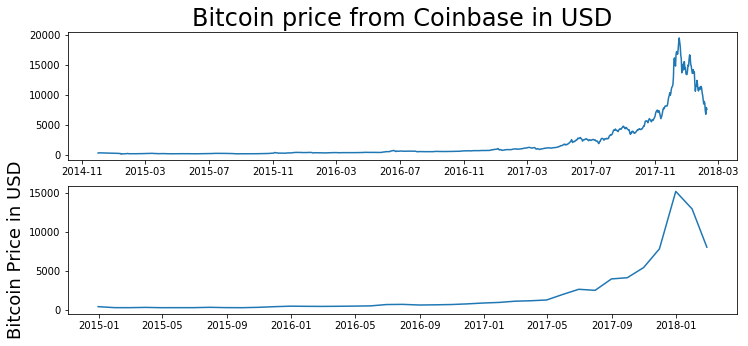

In [12]:
# Visualizing the data
fig = plt.figure()

# Day
plt.subplot(311)
plt.plot(df_day.PriceUSD, '-', label='By Days')
plt.title('Bitcoin price from Coinbase in USD', fontsize=24)

# Month
plt.subplot(312)
plt.plot(df_month.PriceUSD, '-', label='By Months')
plt.ylabel('Bitcoin Price in USD', fontsize=18)

As you can see from the graph, from 2014 to 2016, there's not much price change, so I will be only considering the data from the beginning of 2016.

In [13]:
# The data we are going to use for prediction
data = df_day[(df_day.index > '2016-01-01')]

# Check the shape of the data that we are using
print('Data shape: ',data.shape)

Data shape:  (769, 2)


Let's divide the data into training and testing sets. We will be using 80% of the data as training and the rest as testing. Also, note that the target data labels for training will be one sample ahead of the training samples. In other words, we will be using a previous sample to predict the next sample.

And make sure you normalize the data, I tried without it in the beginning and the loss was nowhere near converging.

In [14]:
# Total length of the data set
tot_len = data.shape[0]

# Normalize the data
data_max = data.PriceUSD.max()
data_min = data.PriceUSD.min()
norm_data = (data.PriceUSD - data_min) / (data_max - data_min)

# Divide the data into training and testing sets
train_len = 0.9
train_data = norm_data[:np.int(tot_len*train_len)]
test_data = norm_data[np.int(tot_len*train_len):]
train_target = norm_data[1:np.int(tot_len*train_len)+1]

# Just for checking the dimensions
print('Train data shape:',train_data.shape)
print('Test data shape:',test_data.shape)
print('Train target shape:',train_target.shape)

A = np.reshape(train_data, [-1, 1, 1])
B = np.reshape(train_target, [-1, 1])
C = np.reshape(test_data, [-1, 1, 1])

Train data shape: (692,)
Test data shape: (77,)
Train target shape: (692,)


/home/snakagom/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Here, I'm making a helper function to split the data into chunks. This is particularly important in training RNN because if you feed the entire time series, when you backpropagate, the gradient will vanish. Therefore, we are reshaping the dataset in a batch size chunks and train the network with the mini-batches.

In [15]:
def chunking(x, future_step):
    # Initialize the sequence and the next value
    seq = []
    next_val = []
    # Based on the batch size and the future step size,
    # run a for loop to create chunks.
    # Here, it's BATCH_SIZE - 1 because we are trying to predict
    # one sample ahead. You could change this to your own way
    # e.g. want to predict 5 samples ahead, then - 5
    for i in range(0, len(x) - BATCH_SIZE - future_step, future_step):
        seq.append(x[i: i + BATCH_SIZE])
        next_val.append(x[i + BATCH_SIZE + future_step - 1])
    
    # So now the data is [Samples, Batch size, One step prediction]
    seq = np.reshape(seq, [-1, BATCH_SIZE, 1])
    next_val = np.reshape(next_val, [-1, 1])
    
    X = np.array(seq)
    Y = np.array(next_val)
    
    return X,Y

# Use the above helper function to prepare the data
trainX, trainY = chunking(train_data, 1)
testX, testY = chunking(test_data, 1)

# As an example, you can see the dimensions are samples x batch_size x 1 sample
print(trainX.shape)

(659, 32, 1)


## Using tflearn to make a simple RNN model

From here, we are going to construct a simple RNN (Recurrent Neural Network) model using tflearn which is a higher level API of tensorflow.

In [16]:
# Just for jupyter notebook have this line to avoid index-error\
# You can remove this when you are running the entire code on pure python
tf.reset_default_graph()

# Defining the RNN function
def RNN(activator, optimizer):
    # Building network
    net = tflearn.input_data(shape=[None, BATCH_SIZE, 1])
    # Here, I'm just using the most basic rnn cell type
    # You could also replace the following with tflearn.lstm or tflearn.gru
    net = tflearn.layers.recurrent.simple_rnn(net, NUM_HIDDEN, dropout=0.9, bias=True)
    net = tflearn.fully_connected(net, 1, activation=activator)
    net = tflearn.regression(net, optimizer=optimizer, loss='mean_square', learning_rate=LEARNING_RATE)
    # You could pass the directory path to the following code to create tensorboard logs
    # model = tflearn.DNN(net, tensorboard_dir='/Documents/TF_practice/tflearn_logs', tensorboard_verbose=3)
    model = tflearn.DNN(net, tensorboard_verbose=3)
    
    return model

# training
model = RNN('sigmoid', 'adam')
model.fit(trainX, trainY, n_epoch=NUM_EPOCHS, validation_set=0.1, batch_size=BATCH_SIZE)

Training Step: 1899  | total loss: 0.00913 | time: 0.122s
| Adam | epoch: 100 | loss: 0.00913 -- iter: 576/593
Training Step: 1900  | total loss: 0.00893 | time: 1.134s
| Adam | epoch: 100 | loss: 0.00893 | val_loss: 0.00974 -- iter: 593/593
--


In [17]:
# testing and predicting
prediction = model.predict(testX)

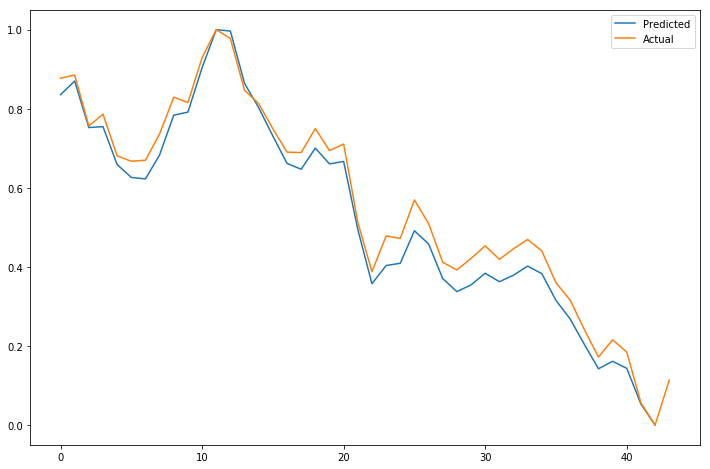

In [18]:
# Scale both the prediction and the target between 0 and 1
max_predict = prediction.max()
min_predict = prediction.min()

scaled_pred = (prediction - min_predict) / (max_predict - min_predict)

max_target = testY.max()
min_target = testY.min()

scaled_target = (testY - min_target) / (max_target - min_target)

plt.plot(scaled_pred[1:], label='Predicted')
plt.plot(scaled_target[0:], label='Actual')
plt.legend()